In [275]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

In [276]:
plt.rcParams.update({"font.size": 15})

# σ+ and σ- polarization

In [277]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=0, F1=1 / 2, F=1
    ),
]

polarizations = [
    [couplings.polarization_σm, couplings.polarization_σp],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [278]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    ω0=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    Pσp0="square_wave(t, ω0, ϕ0)",
    Pσm0="1-Pσp0",
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [279]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [280]:
obe_system.H_symbolic

Matrix([
[      δ0 + 83566.3655475656,                          0,                          0,                          0,                0, 0.4789973066489*Pσm0*Ω0,                         0, -0.478997306884707*Pσp0*Ω0],
[                          0,     δ0 + 0.203834727017238,                          0,                          0,                0,                       0, 0.499999999930402*Pσp0*Ω0,                          0],
[                          0,                          0,                         δ0,                          0,                0,             0.5*Pσm0*Ω0,                         0,  0.499999999890661*Pσp0*Ω0],
[                          0,                          0,                          0,     δ0 - 0.203834671967343,                0,                       0, 0.499999999930402*Pσm0*Ω0,                          0],
[                          0,                          0,                          0,                          0, 256817005301.495,        

In [281]:
[qn.largest for qn in obe_system.QN]

[|X, J = 0, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = None, F = None, mF = None, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>]

In [282]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [283]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 0>",0.666454
"|X, J = 2>",0.333546


In [284]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_excited=False
)

,"|B, J = 1, F₁ = 1/2, F = 1, mF = -1>","|B, J = 1, F₁ = 1/2, F = 1, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = 1>"
states,,,
"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>",6.987578e-02,6.987578e-02,6.987578e-02
"|X, J = 0, F₁ = 1/2, F = 1, mF = -1>",7.613784e-02,7.613784e-02,0.000000e+00
"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>",7.613784e-02,0.000000e+00,7.613784e-02
"|X, J = 0, F₁ = 1/2, F = 1, mF = 1>",0.000000e+00,7.613784e-02,7.613784e-02
"|X, J = 2, F₁ = 3/2, F = 1, mF = -1>",8.326067e-03,8.326067e-03,0.000000e+00
"|X, J = 2, F₁ = 3/2, F = 1, mF = 0>",8.326067e-03,0.000000e+00,8.326066e-03
"|X, J = 2, F₁ = 3/2, F = 1, mF = 1>",0.000000e+00,8.326067e-03,8.326066e-03
"|X, J = 2, F₁ = 3/2, F = 2, mF = -2>",5.667723e-02,0.000000e+00,0.000000e+00
"|X, J = 2, F₁ = 3/2, F = 2, mF = -1>",2.833862e-02,2.833862e-02,0.000000e+00


In [285]:
couplings.generate_coupling_dataframe(obe_system.couplings[0], obe_system.QN)[0]

,ground,excited,couplings
0,"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = -1>",0.457851+0.000000j
1,"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = -1>",0.477926+0.000000j
2,"|X, J = 0, F₁ = 1/2, F = 1, mF = 1>","|B, J = 1, F₁ = 1/2, F = 1, mF = 0>",0.477926+0.000000j


In [286]:
couplings.generate_coupling_dataframe(obe_system.couplings[0], obe_system.QN)[1]

,ground,excited,couplings
0,"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = 1>",-0.457851+0.000000j
1,"|X, J = 0, F₁ = 1/2, F = 1, mF = -1>","|B, J = 1, F₁ = 1/2, F = 1, mF = 0>",0.477926+0.000000j
2,"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = 1>",0.477926+0.000000j


In [287]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=[0, 1], electronic=states.ElectronicState.X),
    obe_system.QN,
)

In [288]:
odepars.Ωl0 = 1 * hamiltonian.Γ * obe_system.couplings[0].main_coupling.real

In [289]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-6))
config = lindblad_julia.OBEProblemConfig(
    method="Tsit5()", saveat=1e-6, abstol=1e-13, reltol=1e-10
)

results = lindblad_julia.do_simulation_single(problem, config=config)

In [290]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

qn_select_J0 = states.QuantumSelector(J=0, electronic=states.ElectronicState.X)
indices_J0 = qn_select_J0.get_indices(obe_system.QN)

In [291]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J0
]
labels

['|F = 0, mF = 0>', '|F = 1, mF = -1>', '|F = 1, mF = 0>', '|F = 1, mF = 1>']

1.89 photons


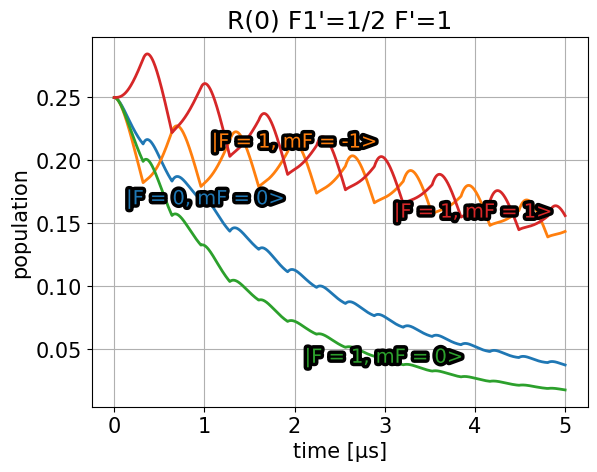

In [292]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_J0].T, lw=2, label=labels)

labelLines(ax.get_lines(), align=False, fontsize=14, outline_color="k")

# ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.set_title("R(0) F1'=1/2 F'=1")

ax.grid()

nphotons = np.trapezoid(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

In [293]:
E = utils.rabi.rabi_to_electric_field(
    rabi=odepars.Ωl0,
    coupling=obe_system.couplings[0].main_coupling,
    D=2.6675506e-30,
)
I = utils.rabi.electric_field_to_intensity(E).real * 1e3 / 1e4
print(f"I  = {I:.2f} mW/cm^2")

I  = 19.93 mW/cm^2


1.89 photons


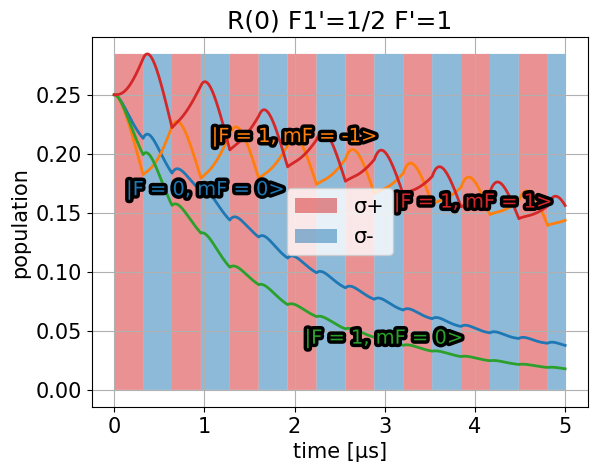

In [294]:
fig, ax = plt.subplots()


ax.plot(results.t * 1e6, results.y[indices_J0].T, lw=2, label=labels)

labelLines(ax.get_lines(), align=False, fontsize=14, outline_color="k")

ax.fill_between(
    results.t * 1e6,
    odepars.get_parameter_evolution(results.t, "Pσp0") * results.y[indices_J0].max(),
    color="tab:red",
    alpha=0.5,
    edgecolor=None,
    label="σ+",
)
ax.fill_between(
    results.t * 1e6,
    odepars.get_parameter_evolution(results.t, "Pσm0") * results.y[indices_J0].max(),
    color="tab:blue",
    alpha=0.5,
    edgecolor=None,
    label="σ-",
)

# ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.set_title("R(0) F1'=1/2 F'=1")

legend_handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(legend_handles[-2:], legend_labels[-2:])

ax.grid()

nphotons = np.trapezoid(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

In [320]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=1, mF=-1, electronic=states.ElectronicState.X),
    obe_system.QN,
)


In [321]:
odepars.Ωl0 = 1 * hamiltonian.Γ * obe_system.couplings[0].main_coupling.real
odepars.ω0 = 0.0


In [330]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-6))
config = lindblad_julia.OBEProblemConfig(
    method="Tsit5()", saveat=1e-6, abstol=1e-13, reltol=1e-10
)

results = lindblad_julia.do_simulation_single(problem, config=config)


In [331]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

qn_select_J0 = states.QuantumSelector(J=0, electronic=states.ElectronicState.X)
indices_J0 = qn_select_J0.get_indices(obe_system.QN)


In [332]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J0
]
labels


['|F = 0, mF = 0>', '|F = 1, mF = -1>', '|F = 1, mF = 0>', '|F = 1, mF = 1>']

1.46 photons


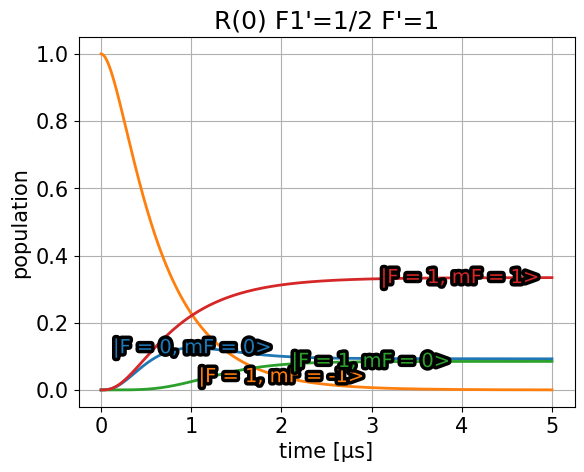

In [333]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_J0].T, lw=2, label=labels)

labelLines(ax.get_lines(), align=False, fontsize=14, outline_color="k")

# ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.set_title("R(0) F1'=1/2 F'=1")

ax.grid()

nphotons = np.trapezoid(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")


# X and Z polarization

In [32]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=0, F1=1 / 2, F=1
    ),
]

polarizations = [
    [couplings.polarization_Z, couplings.polarization_X],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [33]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    ω0=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    PX0="square_wave(t, ω0, ϕ0)",
    PZ0="1-PX0",
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [34]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [35]:
obe_system.H_symbolic

Matrix([
[                        δ0,                          0,                          0,                          0,                0, -0.353553390506304*PX0*Ω0,                0.5*PZ0*Ω0,  0.353553390680357*PX0*Ω0],
[                         0,      δ0 - 83566.1617128386,                          0,                          0,                0, -0.521923602619182*PZ0*Ω0, -0.369055718632925*PX0*Ω0,                         0],
[                         0,                          0,      δ0 - 83566.3655475656,                          0,                0, -0.369055718684297*PX0*Ω0,                         0, -0.369055718603592*PX0*Ω0],
[                         0,                          0,                          0,      δ0 - 83566.5693822375,                0,                         0, -0.369055718632926*PX0*Ω0,  0.521923602505049*PZ0*Ω0],
[                         0,                          0,                          0,                          0, 256817005329.751,         

In [36]:
[qn.largest for qn in obe_system.QN]

[|X, J = 0, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = None, F = None, mF = None, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>]

In [37]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [38]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 0>",0.666454
"|X, J = 2>",0.333546


In [39]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_excited=True
)

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>",0.209627
"|X, J = 0, F₁ = 1/2, F = 1, mF = -1>",0.152276
"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>",0.152276
"|X, J = 0, F₁ = 1/2, F = 1, mF = 1>",0.152276
"|X, J = 2, F₁ = 3/2, F = 1, mF = -1>",0.016652
"|X, J = 2, F₁ = 3/2, F = 1, mF = 0>",0.016652
"|X, J = 2, F₁ = 3/2, F = 1, mF = 1>",0.016652
"|X, J = 2, F₁ = 3/2, F = 2, mF = -2>",0.056677
"|X, J = 2, F₁ = 3/2, F = 2, mF = -1>",0.056677


In [40]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_excited=True
)

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>",0.209627
"|X, J = 0, F₁ = 1/2, F = 1, mF = -1>",0.152276
"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>",0.152276
"|X, J = 0, F₁ = 1/2, F = 1, mF = 1>",0.152276
"|X, J = 2, F₁ = 3/2, F = 1, mF = -1>",0.016652
"|X, J = 2, F₁ = 3/2, F = 1, mF = 0>",0.016652
"|X, J = 2, F₁ = 3/2, F = 1, mF = 1>",0.016652
"|X, J = 2, F₁ = 3/2, F = 2, mF = -2>",0.056677
"|X, J = 2, F₁ = 3/2, F = 2, mF = -1>",0.056677


In [41]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=[0, 1], electronic=states.ElectronicState.X),
    obe_system.QN,
)

In [42]:
odepars.Ωl0 = 1 * hamiltonian.Γ * obe_system.couplings[0].main_coupling.real

In [43]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-6))
config = lindblad_julia.OBEProblemConfig(
    method="Tsit5()", saveat=1e-6, abstol=1e-13, reltol=1e-10
)

results = lindblad_julia.do_simulation_single(problem, config=config)

In [44]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

qn_select_J0 = states.QuantumSelector(J=0, electronic=states.ElectronicState.X)
indices_J0 = qn_select_J0.get_indices(obe_system.QN)

In [45]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J0
]
labels

['|F = 0, mF = 0>', '|F = 1, mF = -1>', '|F = 1, mF = 0>', '|F = 1, mF = 1>']

1.88 photons


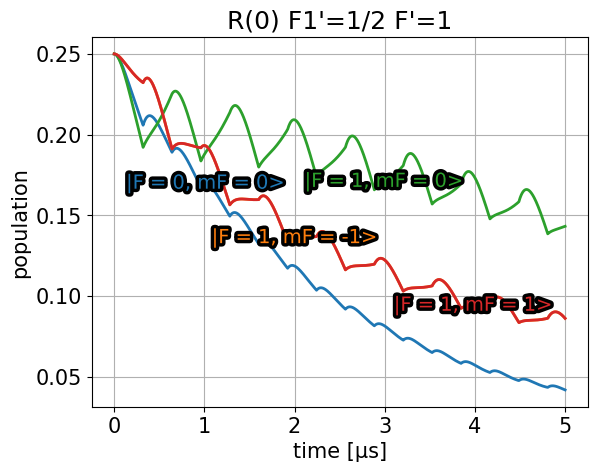

In [46]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_J0].T, lw=2, label=labels)

labelLines(ax.get_lines(), align=False, fontsize=14, outline_color="k")

# ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.set_title("R(0) F1'=1/2 F'=1")

ax.grid()

nphotons = np.trapezoid(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

In [47]:
E = utils.rabi.rabi_to_electric_field(
    rabi=odepars.Ωl0,
    coupling=obe_system.couplings[0].main_coupling,
    D=2.6675506e-30,
)
I = utils.rabi.electric_field_to_intensity(E).real * 1e3 / 1e4
print(f"I  = {I:.2f} mW/cm^2")

I  = 19.93 mW/cm^2


1.88 photons


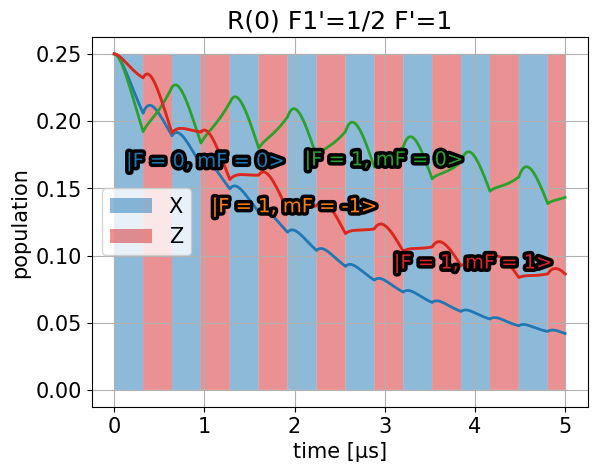

In [49]:
fig, ax = plt.subplots()


ax.plot(results.t * 1e6, results.y[indices_J0].T, lw=2, label=labels)

labelLines(ax.get_lines(), align=False, fontsize=14, outline_color="k")

ax.fill_between(
    results.t * 1e6,
    odepars.get_parameter_evolution(results.t, "PX0") * results.y[indices_J0].max(),
    color="tab:blue",
    alpha=0.5,
    edgecolor=None,
    label="X",
)
ax.fill_between(
    results.t * 1e6,
    odepars.get_parameter_evolution(results.t, "PZ0") * results.y[indices_J0].max(),
    color="tab:red",
    alpha=0.5,
    edgecolor=None,
    label="Z",
)

# ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.set_title("R(0) F1'=1/2 F'=1")

legend_handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(legend_handles[-2:], legend_labels[-2:])

ax.grid()

nphotons = np.trapezoid(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

In [250]:
from dataclasses import dataclass
from itertools import product, combinations
from sympy.utilities.iterables import flatten
import sympy as smp

n_levels = 4


@dataclass
class Transformation:
    n_levels: int
    a_symbols: list
    Δ_symbols: list
    T: smp.matrices.dense.MutableDenseMatrix


def generate_transform_matrix_symbolic(n_levels=4, ind_T_zero=[0, 2]):
    δ = smp.symbols("δ", real=True)
    Ω = smp.Symbol("Ω", real=True)

    # T = smp.MatrixSymbol('T',,4)
    T = smp.zeros(n_levels, n_levels)
    for idx, idy in product(*[range(n_levels - 1)] * 2):
        T[idx, idy] = smp.Symbol(f"T{idx}{idy}", real=True)
    T[n_levels - 1, n_levels - 1] = 1

    a = smp.symbols([f"a_{i}" for i in range(n_levels - 1)], real=True)
    Δ = smp.symbols([f"Δ_{i}" for i in range(n_levels - 1)], real=True)

    H = smp.zeros(n_levels, n_levels)
    for i in range(n_levels - 1):
        H[i, i] = -δ + Δ[i]

    for i in range(n_levels - 1):
        H[i, n_levels - 1] = 1 / 2 * a[i] * Ω
        H[n_levels - 1, i] = smp.conjugate(H[i, n_levels - 1])

    transformed = smp.simplify(T.T @ H @ T)

    # ensure one bright state and n_levels-2 dark states
    eqns = [smp.Eq(transformed[i, n_levels - 1], 0) for i in range(1, n_levels - 1)]

    sol = smp.solve(eqns)

    T = T.subs(sol[0])

    # ensure the transformation matrix is unitary
    eqns = []

    # set a coupling to zero to the first state, such that this state is the
    # 'darkest' state with no direct coupling to the bright state
    if (n_levels > 3) & (ind_T_zero is not None):
        eqns.append(smp.Eq(T[ind_T_zero[0], ind_T_zero[1]], 0))

    for i in range(n_levels - 1):
        eqns.append(smp.Eq(T[:, i].dot(T[:, i]), 1))
    for i, j in combinations(range(n_levels - 1), 2):
        eqns.append(smp.Eq(T[:, i].dot(T[:, j]), 0))

    solve_symbols = [sym for sym in T.free_symbols if sym not in [Ω, δ, *a, *Δ]]
    # for some reason this order of symbols solves faster
    solve_symbols = [
        T[i, j]
        for i, j in product(*[range(n_levels - 1)] * 2)
        if T[i, j] in solve_symbols
    ]

    sol = smp.solve(eqns, *solve_symbols)
    T = T.subs([(s, v) for s, v in zip(solve_symbols, sol[0])])

    return Transformation(n_levels, a, Δ, T)


In [251]:
three_level_transform = generate_transform_matrix_symbolic(n_levels=3)
four_level_transform = generate_transform_matrix_symbolic(n_levels=4)


In [252]:
def convert_transformation_to_hamiltonian(
    indices, obe_system, transformation, replacements, Ωval=1
):
    Ω = smp.Symbol("Ω0", complex=True)
    Ωᶜ = smp.Symbol("Ω0ᶜ", complex=True)

    idx_excited = indices[0][1]
    indices_ground = [idx for idx in np.unique(indices) if idx != idx_excited]

    transform = transformation.T

    for idg, a_symbol in zip(indices_ground, transformation.a_symbols):
        coupling = obe_system.H_symbolic[idg, idx_excited]
        coupling = coupling.subs([(Ω, Ωval), (Ωᶜ, Ωval)])
        coupling = coupling.subs(*replacements)
        transform = transform.subs(a_symbol, coupling)

    return np.asarray(transform, dtype=float)


In [253]:
def generate_transformation_matrix_hamiltonian_basis(
    obe_system, indices_coupling, transformations, replacements
):
    transformed = np.eye(len(obe_system.QN))

    for (idx_excited, cpls), transformation, replacement in zip(
        indices_coupling.items(), transformations, replacements
    ):
        T_numeric = convert_transformation_to_hamiltonian(
            cpls, obe_system, transformation, replacement
        )
        index = [idx for idx in np.unique(cpls) if idx != idx_excited]
        for i, idx in enumerate(index):
            transformed[:, idx] = 0
            for j, idy in enumerate(index):
                transformed[idy, idx] = T_numeric[j, i]
    return transformed


In [254]:
def group_by_excited(lst):
    grouped = {}
    for x, y in lst:
        if y in grouped:
            grouped[y].append((x, y))
        else:
            grouped[y] = [(x, y)]
    return grouped


def get_coupling_indices(obe_system):
    coupled_states = []

    coupling_indices_per_field = []
    for cf in obe_system.couplings[0].fields:
        coupling_indices = []
        c_indices = np.nonzero(cf.field)
        c_indices = [ci[: len(ci) // 2] for ci in c_indices]
        for i, j in zip(*c_indices):
            coupled_states.append(i)
            coupling_indices.append((i, j))
        coupling_indices = group_by_excited(coupling_indices)
        coupling_indices_per_field.append(coupling_indices)
    return coupling_indices_per_field


In [257]:
coupling_indices = get_coupling_indices(obe_system)
coupling_indices


[{np.int64(6): [(np.int64(0), np.int64(6))],
  np.int64(5): [(np.int64(1), np.int64(5))],
  np.int64(7): [(np.int64(3), np.int64(7))]},
 {np.int64(5): [(np.int64(0), np.int64(5)), (np.int64(2), np.int64(5))],
  np.int64(7): [(np.int64(0), np.int64(7)), (np.int64(2), np.int64(7))],
  np.int64(6): [(np.int64(1), np.int64(6)), (np.int64(3), np.int64(6))]}]

In [255]:
transition_selectors[0].polarization_symbols

[PZ0, PX0]

In [256]:
three_level_transform

Transformation(n_levels=3, a_symbols=[a_0, a_1], Δ_symbols=[Δ_0, Δ_1], T=Matrix([
[-a_0/sqrt(a_0**2 + a_1**2),  a_1/sqrt(a_0**2 + a_1**2), 0],
[-a_1/sqrt(a_0**2 + a_1**2), -a_0/sqrt(a_0**2 + a_1**2), 0],
[                         0,                          0, 1]]))

In [258]:
transformed = generate_transformation_matrix_hamiltonian_basis(
    obe_system,
    {np.int64(6): [(np.int64(1), np.int64(6)), (np.int64(3), np.int64(6))]},
    [three_level_transform],
    [(transition_selectors[0].polarization_symbols[-1], 1)],
)


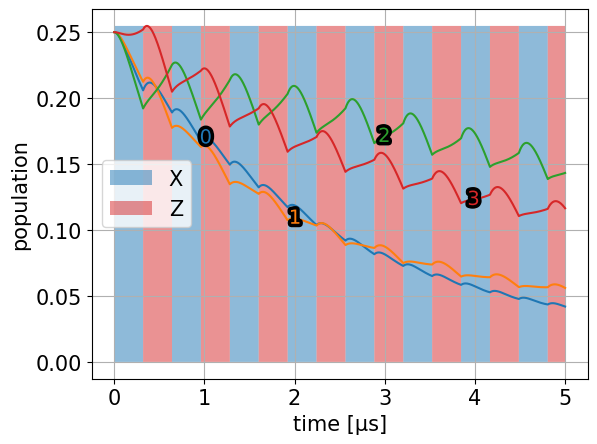

In [259]:
from julia import Main

sol = np.array(Main.eval("sol[:]"))
sol = transformed.T @ (sol @ transformed).T
sol = np.einsum("iij -> ij", sol).real

fig, ax = plt.subplots()

ax.plot(results.t * 1e6, sol[indices_J0].T, label=np.arange(len(indices_J0)))

ax.fill_between(
    results.t * 1e6,
    odepars.get_parameter_evolution(results.t, "PX0") * sol[indices_J0].max(),
    color="tab:blue",
    alpha=0.5,
    edgecolor=None,
    label="X",
)
ax.fill_between(
    results.t * 1e6,
    odepars.get_parameter_evolution(results.t, "PZ0") * sol[indices_J0].max(),
    color="tab:red",
    alpha=0.5,
    edgecolor=None,
    label="Z",
)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), align=False, fontsize=14, outline_color="k")

legend_handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(legend_handles[-2:], legend_labels[-2:])

ax.grid(True)


In [274]:
transformed.T @ obe_system.H_symbolic @ transformed

Matrix([
[                    1.0*δ0,                          0,                          0,                            0,                0, -0.353553390506304*PX0*Ω0,                  0.5*PZ0*Ω0,  0.353553390680357*PX0*Ω0],
[                         0,  1.0*δ0 - 83566.3655475381,                          0,           -0.203834699488652,                0, -0.369055718673337*PZ0*Ω0,   -0.521923602562032*PX0*Ω0,  0.369055718592633*PZ0*Ω0],
[                         0,                          0,  1.0*δ0 - 83566.3655475656,                            0,                0, -0.369055718684297*PX0*Ω0,                           0, -0.369055718603592*PX0*Ω0],
[                         0,         -0.203834699488652,                          0,    1.0*δ0 - 83566.3655475381,                0,  0.369055718673337*PZ0*Ω0, 5.55111512312578e-17*PX0*Ω0,  0.369055718592633*PZ0*Ω0],
[                         0,                          0,                          0,                            0, 25681700

In [271]:
couplings.generate_coupling_dataframe(obe_system.couplings[0], obe_system.QN)[0]

,ground,excited,couplings
0,"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = 0>",-0.457851+0.000000j
1,"|X, J = 0, F₁ = 1/2, F = 1, mF = -1>","|B, J = 1, F₁ = 1/2, F = 1, mF = -1>",0.477926+0.000000j
2,"|X, J = 0, F₁ = 1/2, F = 1, mF = 1>","|B, J = 1, F₁ = 1/2, F = 1, mF = 1>",-0.477926+0.000000j


In [270]:
couplings.generate_coupling_dataframe(obe_system.couplings[0], obe_system.QN)[-1]

,ground,excited,couplings
0,"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = -1>",0.323749+0.000000j
1,"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = 1>",-0.323749+0.000000j
2,"|X, J = 0, F₁ = 1/2, F = 1, mF = -1>","|B, J = 1, F₁ = 1/2, F = 1, mF = 0>",0.337945+0.000000j
3,"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = -1>",0.337945+0.000000j
4,"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = 1>",0.337945+0.000000j
5,"|X, J = 0, F₁ = 1/2, F = 1, mF = 1>","|B, J = 1, F₁ = 1/2, F = 1, mF = 0>",0.337945+0.000000j


In [266]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_excited=True
)


,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>",0.209627
"|X, J = 0, F₁ = 1/2, F = 1, mF = -1>",0.152276
"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>",0.152276
"|X, J = 0, F₁ = 1/2, F = 1, mF = 1>",0.152276
"|X, J = 2, F₁ = 3/2, F = 1, mF = -1>",0.016652
"|X, J = 2, F₁ = 3/2, F = 1, mF = 0>",0.016652
"|X, J = 2, F₁ = 3/2, F = 1, mF = 1>",0.016652
"|X, J = 2, F₁ = 3/2, F = 2, mF = -2>",0.056677
"|X, J = 2, F₁ = 3/2, F = 2, mF = -1>",0.056677


In [260]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_excited=False
).head()


,"|B, J = 1, F₁ = 1/2, F = 1, mF = -1>","|B, J = 1, F₁ = 1/2, F = 1, mF = 0>","|B, J = 1, F₁ = 1/2, F = 1, mF = 1>"
states,,,
"|X, J = 0, F₁ = 1/2, F = 0, mF = 0>",0.069876,0.069876,0.069876
"|X, J = 0, F₁ = 1/2, F = 1, mF = -1>",0.076138,0.076138,0.000000
"|X, J = 0, F₁ = 1/2, F = 1, mF = 0>",0.076138,0.000000,0.076138
"|X, J = 0, F₁ = 1/2, F = 1, mF = 1>",0.000000,0.076138,0.076138
"|X, J = 2, F₁ = 3/2, F = 1, mF = -1>",0.008326,0.008326,0.000000


1.88 photons


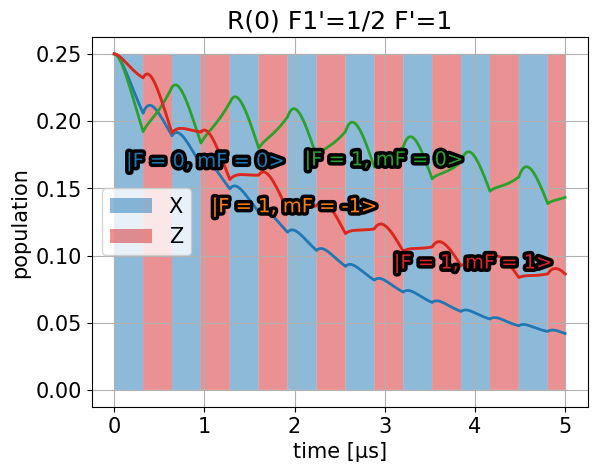

In [261]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_J0].T, lw=2, label=labels)

labelLines(ax.get_lines(), align=False, fontsize=14, outline_color="k")

ax.fill_between(
    results.t * 1e6,
    odepars.get_parameter_evolution(results.t, "PX0") * results.y[indices_J0].max(),
    color="tab:blue",
    alpha=0.5,
    edgecolor=None,
    label="X",
)
ax.fill_between(
    results.t * 1e6,
    odepars.get_parameter_evolution(results.t, "PZ0") * results.y[indices_J0].max(),
    color="tab:red",
    alpha=0.5,
    edgecolor=None,
    label="Z",
)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.set_title("R(0) F1'=1/2 F'=1")

legend_handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(legend_handles[-2:], legend_labels[-2:])

ax.grid()

nphotons = np.trapezoid(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")
